In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Exploratory Data Analysis (EDA)

In [2]:
filepath = r'.\data\housing.csv'
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df = pd.read_csv(filepath, sep = '\s+', header = None, names = column_names)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [4]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


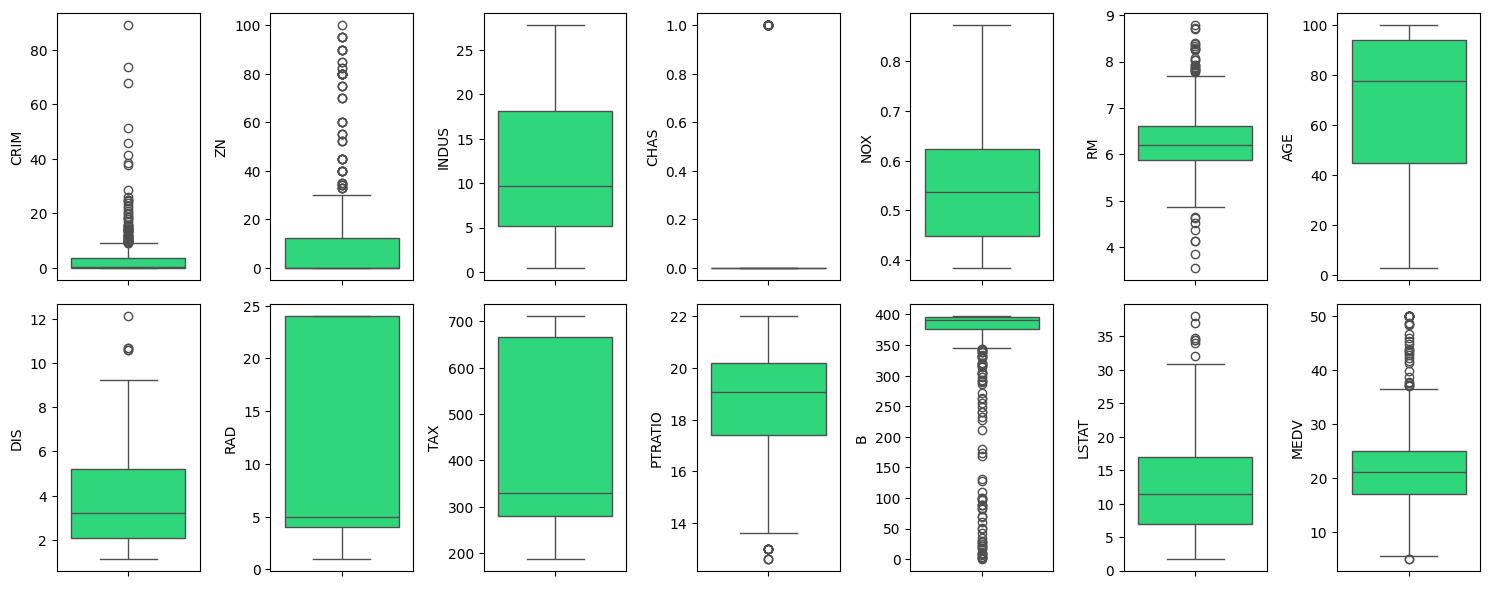

In [5]:
# Box and Whisker Plots
fig, axes = plt.subplots(nrows = 2, ncols = 7, figsize = (15, 6))

axes = axes.flatten()

for i, column in enumerate(df.columns):
    sns.boxplot(y = df[column], data = df, ax = axes[i], color = '#14F278')

plt.tight_layout()
plt.show()

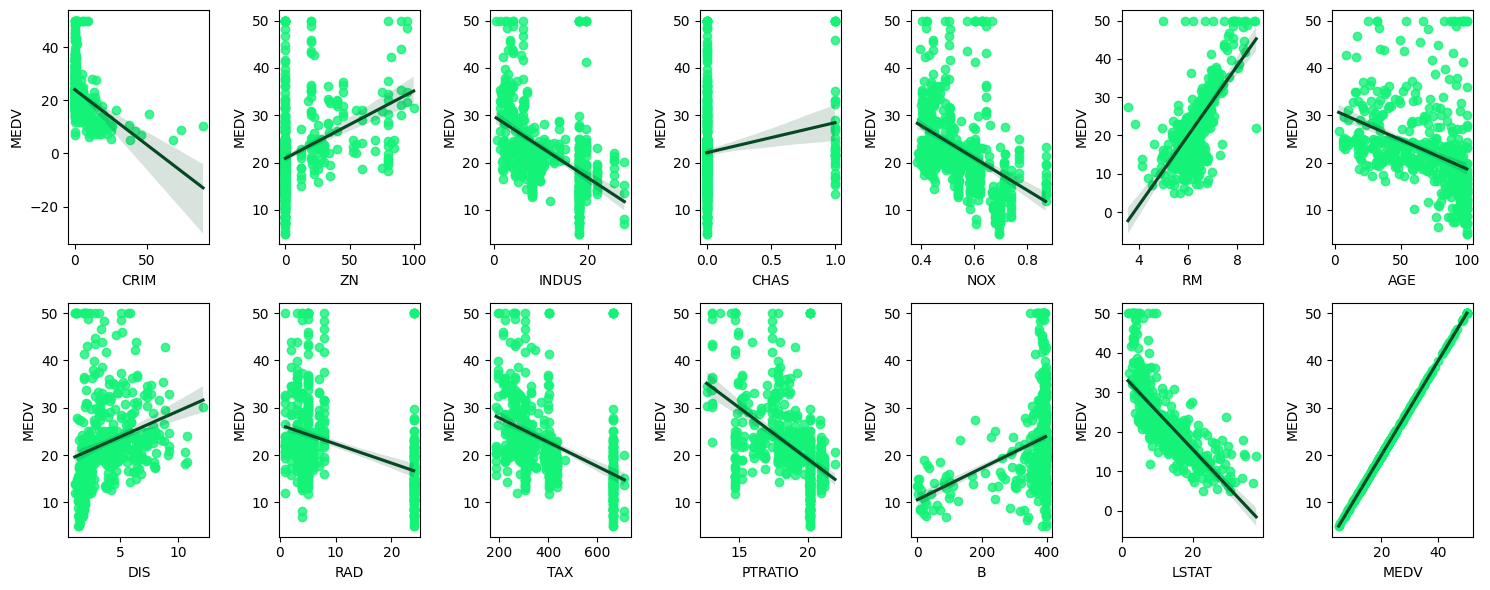

In [6]:
# Scatter Plots
fig, axes = plt.subplots(nrows = 2, ncols = 7, figsize = (15, 6))

axes = axes.flatten()

for i, column in enumerate(df.columns):
    sns.regplot(x = df[column], y = df['MEDV'], data = df, ax = axes[i], color = '#14F278', line_kws = dict(color = '#064824'))

plt.tight_layout()
plt.show()

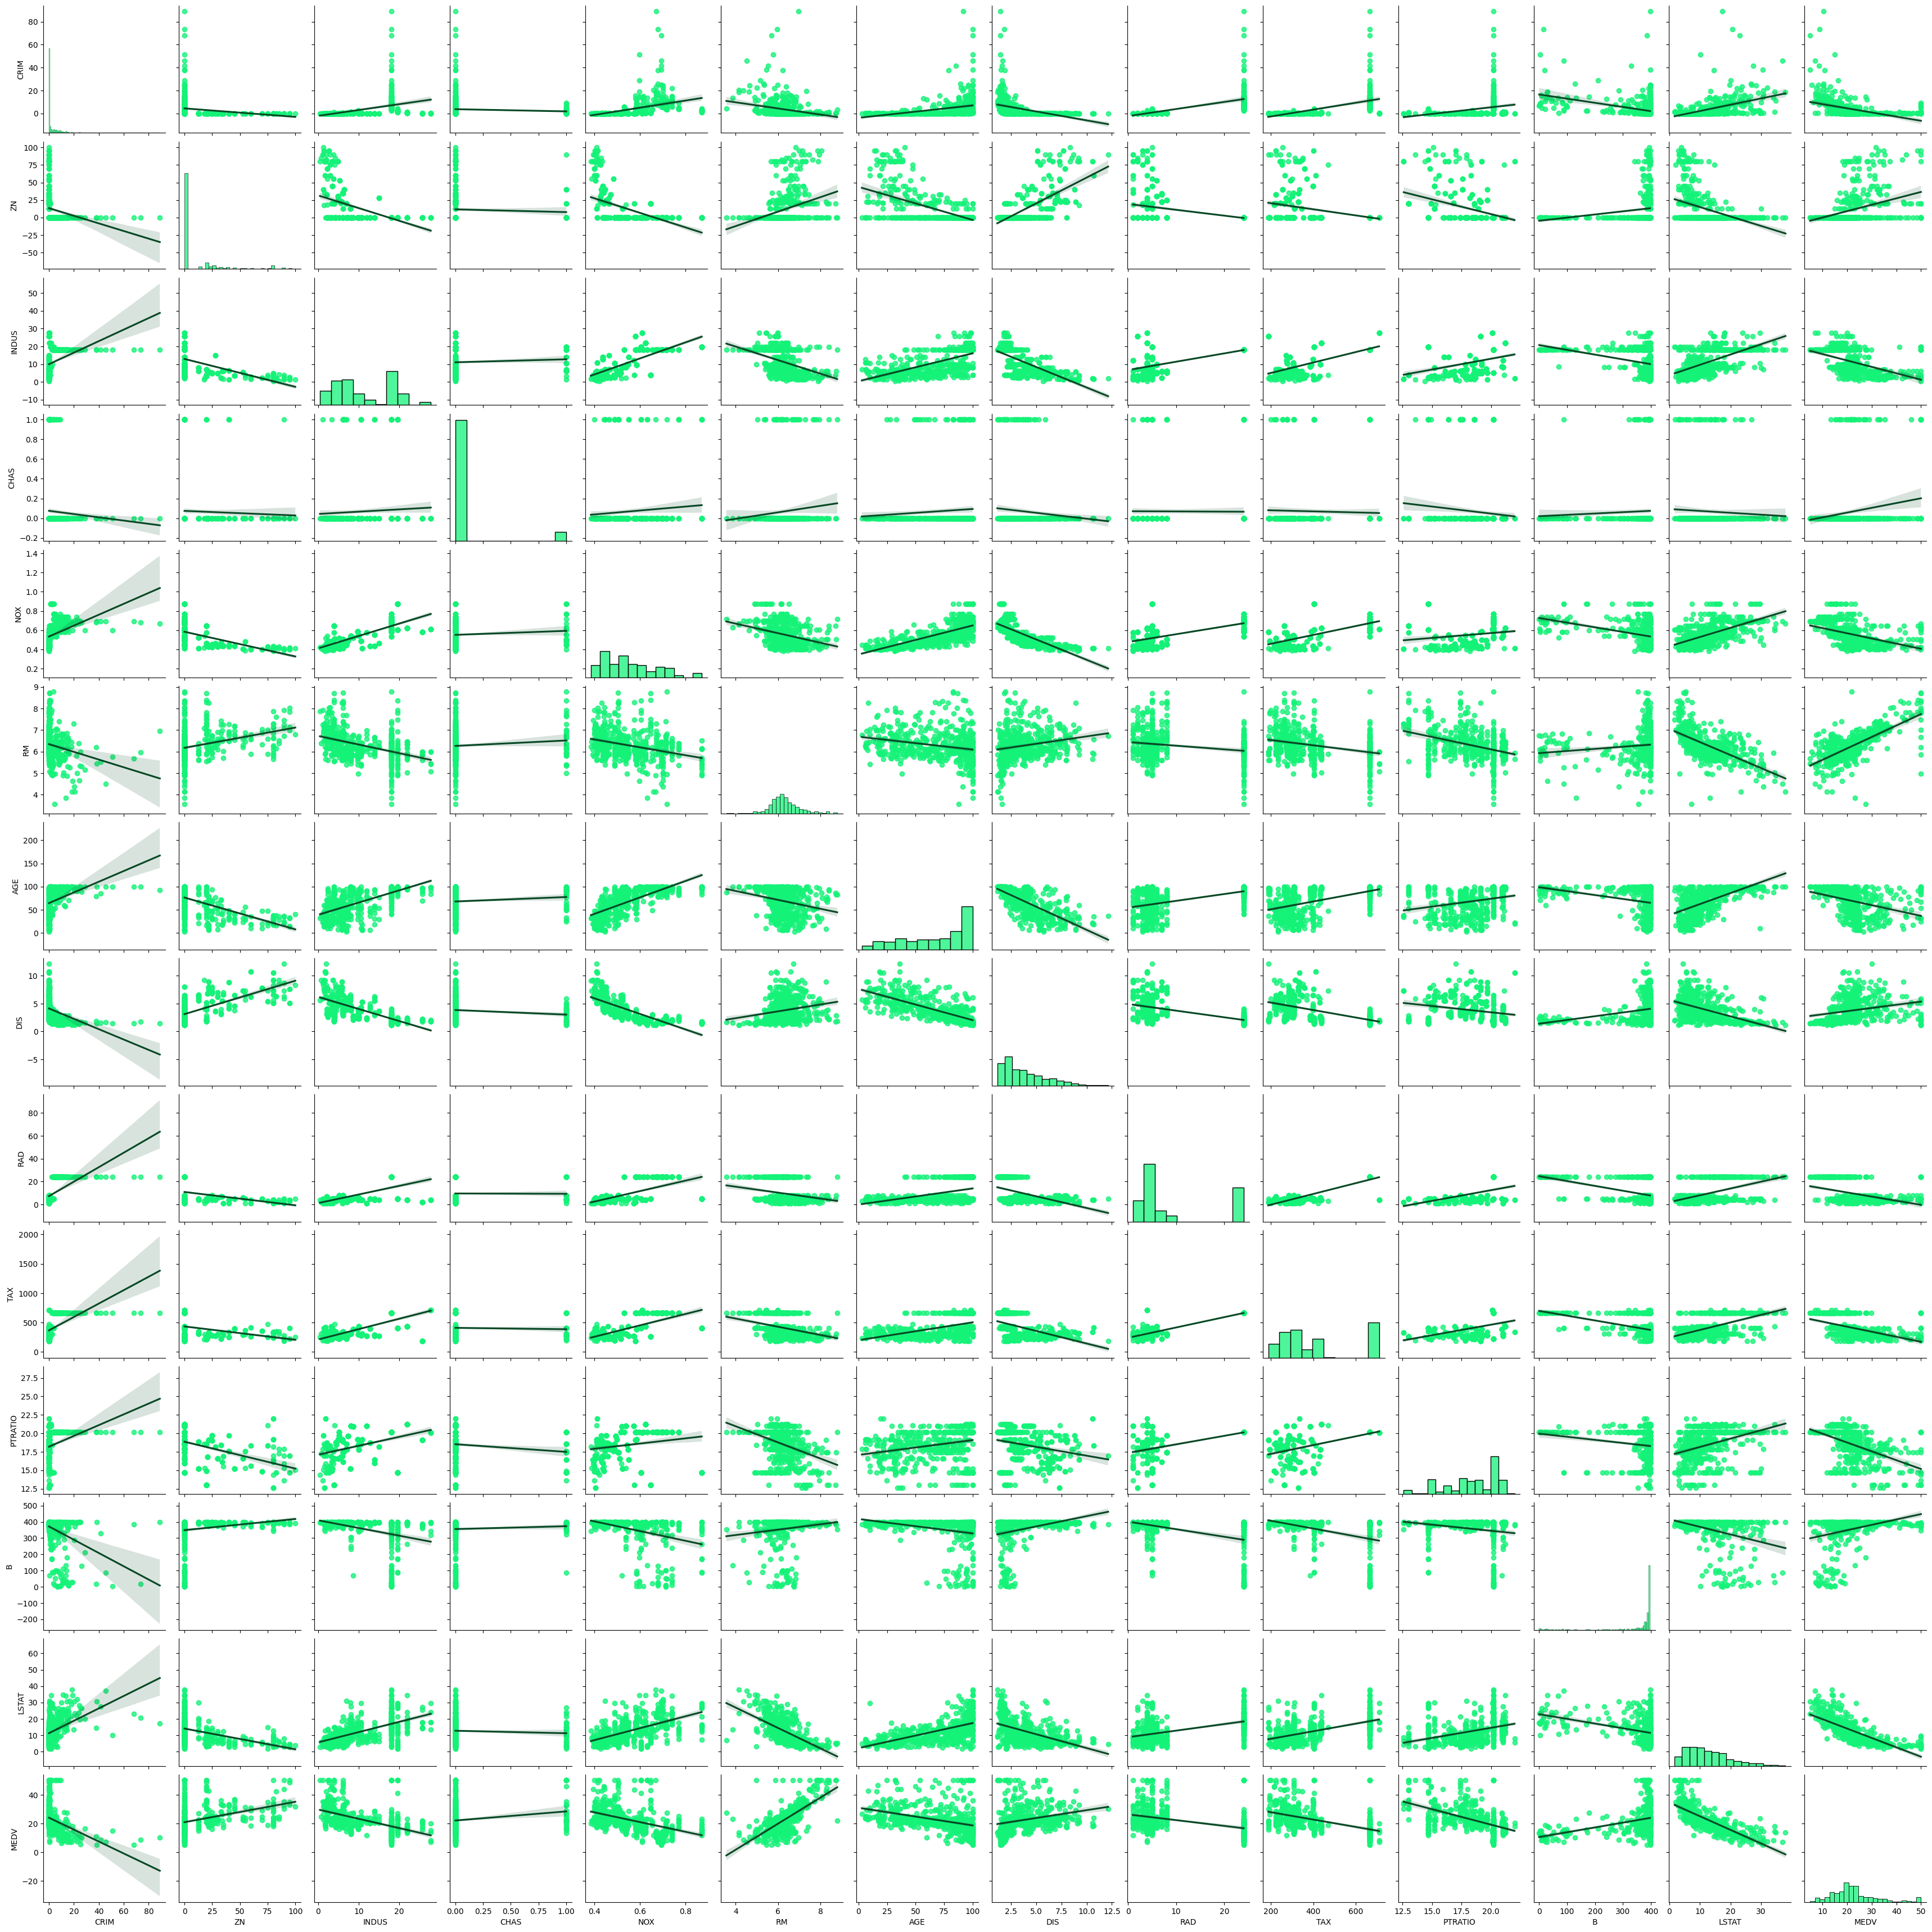

In [7]:
# Pairplot
pairplot = sns.pairplot(df, kind = 'reg', plot_kws={'color': '#14F278', 'line_kws': {'color': '#064824'}}, diag_kws={'color': '#14F278'})
plt.show()

In [8]:
# We wanted to explore MEDV further as it is our target value. We noticed there for RM vs MEDV that there are a few towns with the same MEDV but very different RM values.
# After further investigation we learned that every MEDV value above 50 was rounded down to 50, so we decided to remove those rows.
df = df[~(df['MEDV'] >= 50.0)]
df.shape

(490, 14)

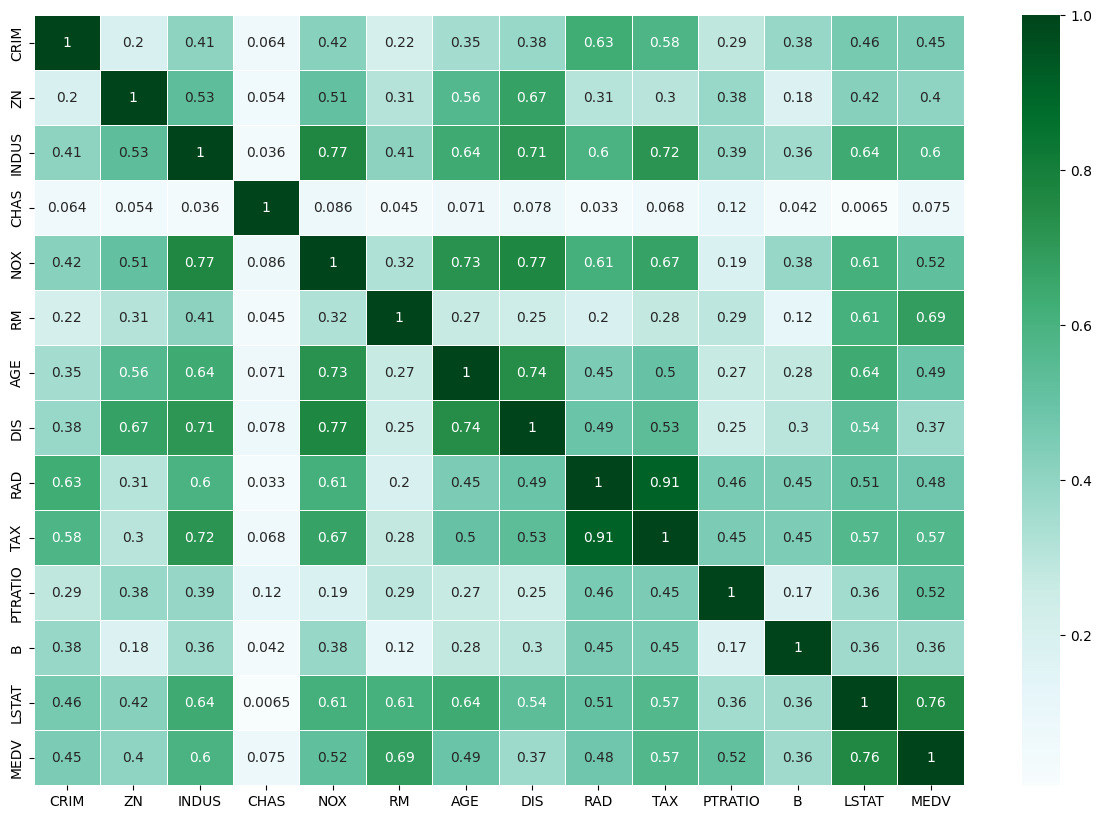

In [9]:
# Correlation Heatmap
corr_df = df.corr().abs()

fig, ax = plt.subplots(figsize = (15, 10))
sns.heatmap(corr_df, annot = True, cmap = 'BuGn', linewidths = 0.5)
plt.show()

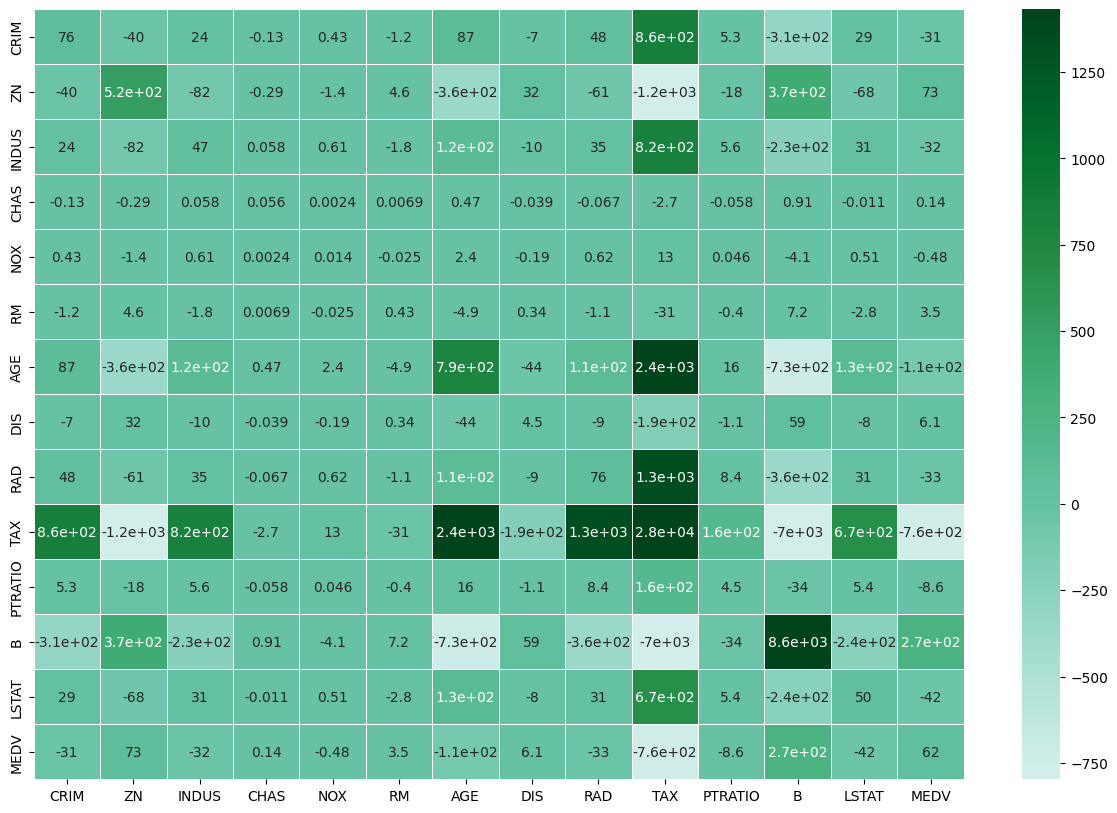

In [10]:
# Covariance Heatmap
cov_df = df.cov()

fig, ax = plt.subplots(figsize = (15, 10))
sns.heatmap(cov_df, annot = True, cmap = 'BuGn', linewidths = 0.5, center = 0, robust = True)
plt.show()

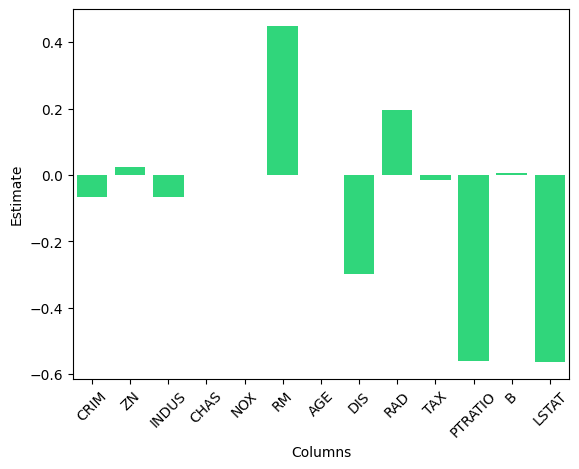

In [11]:
# Lasso Regression
X = df.drop(columns = ['MEDV'])
y = df['MEDV']
 
x_train, x_test, y_train, y_test = train_test_split(X, y,  test_size = 0.20, random_state= 123)
 
model = Lasso(alpha = 1)
model.fit(x_train, y_train)
y_pred1 = model.predict(x_test)
 
lasso = pd.DataFrame()
lasso['Columns'] = x_train.columns
lasso['Estimate'] = pd.Series(model.coef_)
 
sns.barplot(x = lasso['Columns'], y = lasso['Estimate'], color = '#14F278')
plt.xticks(rotation = 45)
plt.show()

### Our Model

In [3]:
X = df[['RM', 'PTRATIO', 'TAX', 'LSTAT']]
y = df['MEDV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

# Initialize an instance of a Gradient Boosting Regression
model = GradientBoostingRegressor()

# Pass Ranges for Hyperparameters
parameters = {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
              'min_samples_leaf': [5, 10, 15, 20]}  

# Initialise a Grid Search object
# passing the decision tree estimator and the parameter grid values
clf = GridSearchCV(estimator = model, param_grid = parameters, cv=5)

# Fit the Grid Search object to the train data
# At this stage, the model is learning the optimal hyperparameter values by performing the Grid Search
clf.fit(X_train, y_train)

# Once the model's hyperparameters are tuned, we can make predictions
y_pred = clf.predict(X_test)

In [4]:
# Retrieve the optimal hyperparamer values, found by Grid Search CV
best_depth = clf.best_estimator_.max_depth
best_min_samples = clf.best_estimator_.min_samples_leaf

print(f'best estimator: depth {best_depth} and min_samples {best_min_samples}')

best estimator: depth 3 and min_samples 5


In [5]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean absolute error is {mae:.4f}')
print(f'MSE (test): {mse:.4f}')
print(f'RMSE (test): {mse**0.5:.4f}')
print(f'R-squared is {r2:.4f}')

Mean absolute error is 2.7360
MSE (test): 23.5950
RMSE (test): 4.8575
R-squared is 0.7148


In [6]:
from gradient_boosting_tree.tree import DecisionTree

model = DecisionTree()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
sns.scatterplot(y_test, y_pred)

InvalidIndexError: (slice(None, None, None), 0)